<div class="alert alert-block alert-info">
    <h2><center>Predicción de precios de insumos básicos en Chile</center></h2>
    <center>Descripción: Hacer un pronóstico del precio de la leche a partir de variables macroeconómicas </center>
</div>

In [1]:
###
# Bibliotecas
###
#Manejo de datos
import random
import os
import pandas as pd
#Bibliotecas cientificas
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_text
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#Computo matricial y númerico
import numpy as np
#Visualizacion
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
#Utilidades
from datetime import datetime
#Bibliotecas de modelado
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Input,Dropout, concatenate, LSTM
from keras.optimizers import Adam
from keras.models import Model

Using TensorFlow backend.


# Contexto

En este desafío vamos a ver si somos capaces de predecir el precio de un insumo básico, como la leche, a partir de variables climatológicas y macroeconómicas

## 1. Datos: Precipitaciones, Indicadores Económicos Banco Central
- Cargar archivo precipitaciones.csv con las precipitaciones medias mensuales registradas entre enero 1979 y abril 2020. (Unidad: mm).
- Cargar archivo banco_central.csv con variables económicas.

In [2]:
#Cargar archivos como variables privadas
_banco_central = pd.read_csv (r'./Datasets/banco_central.csv')
_precio_leche = pd.read_csv (r'./Datasets/precio_leche.csv')
_precipitaciones = pd.read_csv(r'./Datasets/precipitaciones.csv')

pd.set_option('display.max_columns', None)
tf.random.set_seed(
    42
)
np.random.seed(42)

In [3]:
#Fijar un valor de semilla para replicar los experimentos
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## 2. Análisis de los datos. Creación de variables

In [4]:
#Tamaño de muestra
print('Tamaño de muestra del banco central: {}'.format(_banco_central.shape))
print('Tamaño de muestra del precio de la leche: {}'.format(_precio_leche.shape))
print('Tamaño de muestra de las precipitaciones: {}'.format(_precipitaciones.shape))

Tamaño de muestra del banco central: (614, 85)
Tamaño de muestra del precio de la leche: (506, 3)
Tamaño de muestra de las precipitaciones: (496, 9)


In [5]:
#Eliminar duplicados
_banco_central.drop_duplicates(inplace = True)
_precio_leche.drop_duplicates(inplace = True)
_precipitaciones.drop_duplicates(inplace = True)

print('Tamaño de muestra del banco central sin duplicados: {}'.format(_banco_central.shape))
print('Tamaño de muestra del precio de la leche sin duplicados: {}'.format(_precio_leche.shape))
print('Tamaño de muestra de las precipitaciones sin duplicados: {}'.format(_precipitaciones.shape))

Tamaño de muestra del banco central sin duplicados: (612, 85)
Tamaño de muestra del precio de la leche sin duplicados: (506, 3)
Tamaño de muestra de las precipitaciones sin duplicados: (496, 9)


In [6]:
_precio_leche.head() #Punto de partida de la variable target  

Anio  Mes  Precio_leche
0  1979  Ene          3.85
1  1979  Feb          4.58
2  1979  Mar          5.18
3  1979  Abr          6.06
4  1979  May          7.25

In [7]:
_banco_central.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 613
Data columns (total 85 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Periodo                                                                             612 non-null    object 
 1   Imacec_empalmado                                                                    298 non-null    object 
 2   Imacec_produccion_de_bienes                                                         298 non-null    object 
 3   Imacec_minero                                                                       298 non-null    object 
 4   Imacec_industria                                                                    299 non-null    object 
 5   Imacec_resto_de_bienes                                                              298 non-null   

In [8]:
_precio_leche.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Anio          506 non-null    int64  
 1   Mes           506 non-null    object 
 2   Precio_leche  506 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 15.8+ KB


In [9]:
_precipitaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 496 non-null    object 
 1   Coquimbo                             496 non-null    float64
 2   Valparaiso                           496 non-null    float64
 3   Metropolitana_de_Santiago            496 non-null    float64
 4   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64
 5   Maule                                496 non-null    float64
 6   Biobio                               496 non-null    float64
 7   La_Araucania                         496 non-null    float64
 8   Los_Rios                             496 non-null    float64
dtypes: float64(8), object(1)
memory usage: 38.8+ KB


<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
        <li> Primero se realizó una exploración rápida para ver como son los datos con el método .head() </li>
        <li> Al utilizar el método info() para observar como son las variables, es extraño ver que hay muchas columnas con valores tipo objeto, esto indica que los datos están sucios con algún caracter que no es un número</li>
        <li> Además se observa que para la tabla del banco central las cantidades estan separadas dos veces por un punto decimal, al no tener el contexto de la magnitud de la cantidad esta se infirió con el número mas grande de esa columna, por ejemplo, si el número mas grande de la columna esta dado en cientos, entonces los otros números que parecen sucios se bajaron al rango de cientos. También se consultaron fuentes externas para corroborar esta información: <b>https://si3.bcentral.cl/Siete/ES/Siete/Cuadro/CAP_CCNN/MN_CCNN76/CCNN2013_IMACEC_01</b></li>
        <li>También, se puede observar que la variable target comienza su serie en el año de 1979 por lo que las dos tablas restantes deberán ser "recortadas" para que todas las variables comiencen en el mismo punto</li>
        </ul>

</div>

In [10]:
def cambio_fecha_bancos(df):
    """
    Summary: Función para cambiar el formato de fecha de la tabla de bancos, además la fecha se vuelve 
    un índice de la tabla
    Parameters: Dataframe de bancos
    Return: Dataframe de bancos con la fecha en formato year-month-day sin la hora UTC.
    """
    df['Periodo'] = df.Periodo.astype(str)
    df['Periodo'] = df['Periodo'].str.replace('2020-13-01 00:00:00 UTC', '2020-12-01 00:00:00 UTC')
    df['Periodo'] = df['Periodo'].str.replace(' 00:00:00 UTC', '')
    df.loc[:,'Periodo'] = pd.to_datetime(df['Periodo'].astype(str),format='%Y-%m-%d')
    df.set_index('Periodo',inplace=True)
    return df

def cambio_fecha_precipitaciones(df):
    """
    Summary: Función para cambiar de formato la fecha de la tabla de precipitaciones y volverla un índice de la tabla
    Parameters: El dataframe de precipitaciones
    Return: Retorna la tabla con el índice de fecha en el formato year-month-day
    """
    df['date'] = pd.to_datetime(df['date'].astype(str),format='%Y-%m-%d')
    df.set_index('date',inplace=True)
    return df

def cambio_fecha_leche(df):
    """
    Summary: Función para cambiar el formato de la tabla de Precio_leche a través de un reemplazo en su cadena
    Parameters: El dataframe de la tabla de precio_leche
    Return: El dataframe de precio_leche con la fecha especificada en formato year-month-day
    """
    diccionario = {'Ene':'01-01', 
                   'Feb':'02-01', 
                   'Mar':'03-01', 
                   'Abr':'04-01', 
                   'May':'05-01', 
                   'Jun':'06-01', 
                   'Jul':'07-01', 
                   'Ago':'08-01', 
                   'Sep':'09-01',
                   'Oct':'10-01', 
                   'Nov':'11-01', 
                   'Dic':'12-01'}
    df['date'] = df['Anio'].astype(str) + '-' + df['Mes'].astype(str).replace(diccionario)
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df.set_index('date',inplace=True)
    return df[['Precio_leche']]


def medir_missings(df):
    """
    Summary: Función para medir la cantidad de missings por columna de un dataframe. 
            Calcula cuales columnas cuentan con menos del 30% de valores missings
    Parameters: Un pandas.dataframe
    Return: Una lista con las columnas con menos del 30% de valores missings
    """
    features_acc = []
    for col,_ in df.items():
        df_c = df.shape[0]
        print(col, ' : ',df[col].isnull().sum())
        if ((df[col].isnull().sum()*100)/df_c) < 31:
            features_acc.append(col)
    print('Variables con menos del 30% de valores missings: ',features_acc)
    return features_acc
    
def limpia_puntos(columna):
    """
    Summary: Función para reemplazar los puntos de una cadena con un caracter vacio
    Parameters: pandas.Series
    Return: None
    """
    if '.' in str(columna):
        return int(columna.replace('.',''))
    else:
        return 0
    
def quitar_punto_Imacec(x):
    """
    Summary: Retirar un punto de una cadena con mas de un punto
    Parameters: Una cadena
    Retorno: Un valor flotante o un valor nan
        float, el flotante del número"""
    if len(x.split('.')) > 2: #Revisar si hay más de un punto
        return float('.'.join(x.split('.')[0:2])) #Se unen las dos primeras partes de la lista
    else:
        try:
            return float(x) # Si solo tiene un punto se convierte directamente a flotante
        except:
            return np.nan #Devolvemos nada en caso de que no sea un número

def convertir_dolares(x):
    """
    Summary: Fución para cambiar el punto decimal de lugar en una cadena
    Parameters: Un valor str o un vacio
    Return: Flotante o valor nan si el valor de entrada es vacio
    """
    if len(''.join(x.split('.')[0:-1])) > 3:
        cadena = ''.join(x.split('.')[0:-1])
        return float(cadena[0:3]+'.'+cadena[3:5])
    elif len(x.split('.')[0]) <= 3:
        return float(x)
    else:
        return 0
    
def valor_real_Imacec(serie):
    """
    Summary: Función para cambiar al valor real de la escala de los valores en las magnitudes. Al momento de comparar
    los datos de fuente contra la base datos de Chile, vemos que lás magnitudes no rebazan las centenas y ademas
    esta en orden de los 100 los valores máximos, por lo que con esta función aplicaremos una metrica estadística,
    la cuál es el segundo rango interquartíl (25%), esto condensará a la mayoria de los datos reales en este rango,
    y se propondra una medida de olgura de +50 dado el valor de ese rango.
    Parameteres: pandas.Series
    Retorno: pandas.Series con valores flotantes"""
    max_valor = serie.describe()['25%'] + 50 #Obtenemos el valor del rango 25% y le sumamos 50
    lista_elementos = []
    for _,item in serie.items():
        #valor = quitar_punto(item) #Quitamos el punto excedente si es un dato anomalo
        if item > max_valor:
            cadena_valor = str(item).replace('.','')
            valor = float(cadena_valor[0:2] + '.' + cadena_valor[2:-1])
            lista_elementos.append(valor)
        else:
            lista_elementos.append(item) 
    return lista_elementos

def mover_punto_decimal(serie):
    """
    Summary: Función que recibe para cambiar la magnitud de los datos a centenas
    Parameters: pandas.Series
    Return: Lista con flotantes en el orden de las centenas"""
    lista_elementos = []
    for _,item in serie.items():
        try:
            valor = item.replace('.','')
            lista_elementos.append(float(valor[0:3]+'.'+valor[3:-1]))
        except:
            lista_elementos.append(np.nan)
    return lista_elementos

def limpiar_cobre(serie):
    """
    Summary: Función para limpiar la columna que corresponde al valor del cobre
    Parameters: La columna 'Precio_del_cobre_refinado_BML_dolareslibra'
    Return: Una serie con los valores en los rangos correctos
    """
    lista_elementos = []
    for _,item in serie.items():
        if '0' == item[0]: #Caso 0.14
            lista_elementos.append(float(item))
        elif '1' == item[0] and len(item) <= 4: #Caso 1.27
            lista_elementos.append(float(item))
        elif item[0] != '1' and len(item) <= 3: #Caso 756
            lista_elementos.append(float('0'+'.'+item))
        elif (item[0] == '1' or item[0] != '1') and len(item) >= 4: #Caso 12.234.534 
            valor = item.replace('.','')
            lista_elementos.append(float(valor[0]+'.'+valor[1:-1]))
        else:
            lista_elementos.append(np.nan)
    return lista_elementos

def plot_caja_serie_estadistica(df):
    """
    Summary: Función para visualizar las estádisticas básicas para las tablas a analizar.
    Se gráfica la serie de tiempo, las distribuciones con un diagrama de caja y una tabla con estadística descriptiva
    Parameters: Un dataframe
    Return: None
    """
    for columna in df.columns[0:3]:
        aux = pd.DataFrame(df[columna].describe().to_dict(),[0])
        table = pd.DataFrame(data = {'Estadisticas':aux.columns.to_list(),
                                     'Valores':aux.values.tolist()[0]})
        plt.figure(figsize=(14, 14))
        plt.subplot(2, 2, 2)
        df[columna].plot(kind='box')
        plt.subplot(2, 2, 1)
        df[columna].plot.line()
        plt.subplot(2, 1, 2)
        cell_text = []
        for row in range(len(table)):
            cell_text.append(table.iloc[row])
        plt.table(cellText=cell_text, colLabels=table.columns, loc='center')
        plt.figure(figsize=(14, 8))


In [11]:
#Cambio de fechas de las tres tablas a formato YYYY-MM-DD
_banco_central = cambio_fecha_bancos(_banco_central)
_banco_central.sort_values(by='Periodo',inplace=True)

_precio_leche = cambio_fecha_leche(_precio_leche)
_precio_leche.sort_values(by='date',inplace=True)

_precipitaciones = cambio_fecha_precipitaciones(_precipitaciones)
_precipitaciones.sort_values(by='date',inplace=True)


In [12]:
#Recorte de fechas en bancos
_banco_central = _banco_central.loc[_banco_central.index >= '1979-01-01',:]
banco_central_vis = _banco_central.copy() ## Copia para ejercicio de visualización
_banco_central

Imacec_empalmado Imacec_produccion_de_bienes Imacec_minero  \
Periodo                                                                 
1979-01-01              NaN                         NaN           NaN   
1979-02-01              NaN                         NaN           NaN   
1979-03-01              NaN                         NaN           NaN   
1979-04-01              NaN                         NaN           NaN   
1979-05-01              NaN                         NaN           NaN   
...                     ...                         ...           ...   
2020-08-01      101.314.552                 926.876.935   103.697.799   
2020-09-01      103.201.091                 922.072.659   100.589.658   
2020-10-01      108.402.879                 103.551.978   103.153.982   
2020-11-01              NaN                         NaN           NaN   
2020-12-01              NaN                         NaN           NaN   

           Imacec_industria Imacec_resto_de_bienes Imacec_comercio  \
Periodo                                                              
1979-01-01              NaN                    NaN             NaN   
1979-02-01              NaN                    NaN             NaN   
1979-03-01              NaN                    NaN             NaN   
1979-04-01              NaN                    NaN             NaN   
1979-05-01              NaN                    NaN             NaN   
...                     ...                    ...             ...   
2020-08-01      980.026.279            798.286.232     108.232.893   
2020-09-01      100.132.069            793.042.271     111.622.999   
2020-10-01      108.477.999            998.283.785     116.649.655   
2020-11-01              NaN                    NaN             NaN   
2020-12-01              NaN                    NaN     803.222.345   

           Imacec_servicios Imacec_a_costo_de_factores Imacec_no_minero  \
Periodo                                                                   
1979-01-01              NaN                        NaN              NaN   
1979-02-01              NaN                        NaN              NaN   
1979-03-01              NaN                        NaN              NaN   
1979-04-01              NaN                        NaN              NaN   
1979-05-01              NaN                        NaN              NaN   
...                     ...                        ...              ...   
2020-08-01      104.806.496                100.569.037       10.092.332   
2020-09-01      108.317.886                102.561.718      103.388.943   
2020-10-01      109.798.567                108.112.878      108.891.792   
2020-11-01              NaN                        NaN              NaN   
2020-12-01              NaN                        NaN              NaN   

           PIB_Agropecuario_silvicola    PIB_Pesca  PIB_Mineria  \
Periodo                                                           
1979-01-01                        NaN          NaN          NaN   
1979-02-01                        NaN          NaN          NaN   
1979-03-01                        NaN          NaN          NaN   
1979-04-01                        NaN          NaN          NaN   
1979-05-01                        NaN          NaN          NaN   
...                               ...          ...          ...   
2020-08-01                 15.867.781  614.712.298  130.864.273   
2020-09-01                169.746.171  468.872.234  126.941.868   
2020-10-01                        NaN          NaN          NaN   
2020-11-01                        NaN          NaN          NaN   
2020-12-01                        NaN          NaN          NaN   

           PIB_Mineria_del_cobre PIB_Otras_actividades_mineras  \
Periodo                                                          
1979-01-01                   NaN                           NaN   
1979-02-01                   NaN                           NaN   
1979-03-01                   NaN      

In [13]:
#Calcular el número de missings
features_banco_central = medir_missings(_banco_central)

Imacec_empalmado  :  206
Imacec_produccion_de_bienes  :  206
Imacec_minero  :  206
Imacec_industria  :  206
Imacec_resto_de_bienes  :  206
Imacec_comercio  :  205
Imacec_servicios  :  206
Imacec_a_costo_de_factores  :  206
Imacec_no_minero  :  206
PIB_Agropecuario_silvicola  :  411
PIB_Pesca  :  411
PIB_Mineria  :  411
PIB_Mineria_del_cobre  :  411
PIB_Otras_actividades_mineras  :  410
PIB_Industria_Manufacturera  :  411
PIB_Alimentos  :  411
PIB_Bebidas_y_tabaco  :  411
PIB_Textil  :  411
PIB_Maderas_y_muebles  :  411
PIB_Celulosa  :  411
PIB_Refinacion_de_petroleo  :  411
PIB_Quimica  :  411
PIB_Minerales_no_metalicos_y_metalica_basica  :  410
PIB_Productos_metalicos  :  411
PIB_Electricidad  :  411
PIB_Construccion  :  411
PIB_Comercio  :  411
PIB_Restaurantes_y_hoteles  :  411
PIB_Transporte  :  411
PIB_Comunicaciones  :  411
PIB_Servicios_financieros  :  411
PIB_Servicios_empresariales  :  411
PIB_Servicios_de_vivienda  :  411
PIB_Servicios_personales  :  411
PIB_Administracion_pu

In [14]:
#Limpiar las columnas que no se utilizarán
_banco_central = _banco_central.loc[:,features_banco_central]
_banco_central.shape

(504, 9)

In [15]:
#Tratar las columnas para limpiarlas
banco_central = _banco_central.copy()
for column in banco_central.columns:
    if 'Precio_de_la_gasolina' in column:
        banco_central[column] = banco_central[column].astype(str).apply(convertir_dolares)
        banco_central[column] = banco_central[column].fillna(method = 'ffill')
    elif 'Tipo_de_cambio_del_dolar_observado' in column:
        banco_central[column] = banco_central[column].astype(str).apply(convertir_dolares)
        banco_central[column] = banco_central[column].fillna(method = 'ffill')
    elif (('Precio_de_la_onza_troy_de_oro_dolaresoz') or ('Precio_de_la_onza_troy_de_plata_dolaresoz') 
    or ('Precio_del_petroleo_WTI_dolaresbarril')) in column:
        banco_central[column] = banco_central[column].fillna(method = 'ffill')
    elif 'Precio_del_cobre_refinado_BML_dolareslibra' in column:
        banco_central[column] = banco_central[column].fillna(method = 'ffill')
        banco_central[column] = banco_central[column].astype(str)
        banco_central[column] = limpiar_cobre(banco_central[column])
    elif 'Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100' in column:
        banco_central[column] = banco_central[column].astype(str).apply(convertir_dolares)
        banco_central[column] = banco_central[column].fillna(method = 'ffill')
    elif ('Indice_de_produccion_industrial__mineria') in column:
        banco_central[column] = banco_central[column].astype(str)
        banco_central[column] = mover_punto_decimal(banco_central[column])
        banco_central[column] = banco_central[column].fillna(method = 'ffill')
    elif 'Indice_de_produccion_industrial__manufacturera' in column:
        banco_central[column] = banco_central[column].astype(str)
        banco_central[column] = mover_punto_decimal(banco_central[column])
        banco_central[column] = banco_central[column].fillna(method = 'ffill')
        
banco_central = banco_central.fillna(0)

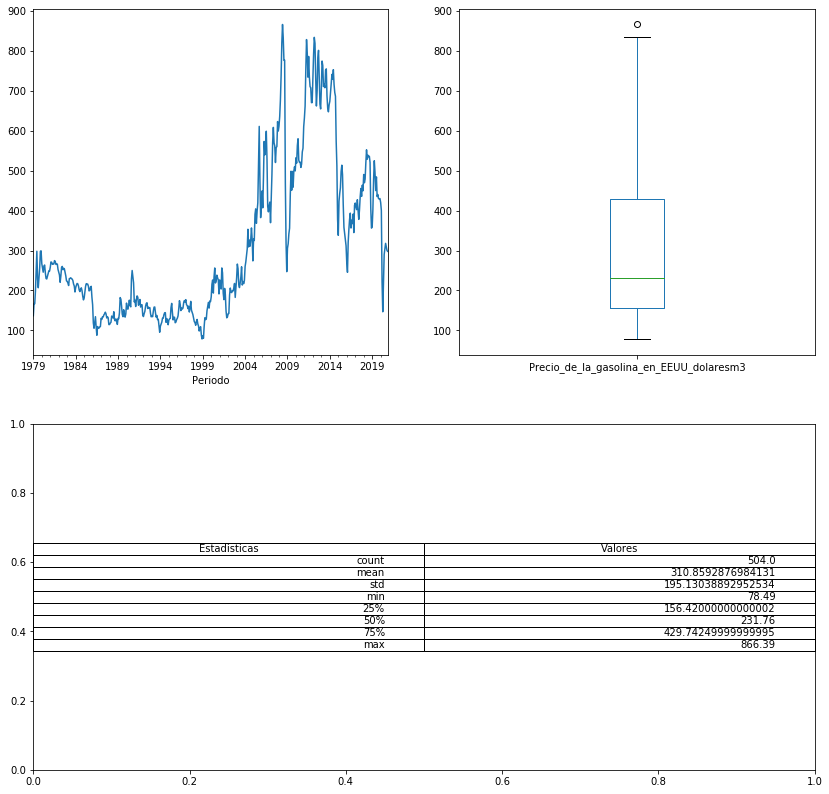

<Figure size 1008x576 with 0 Axes>

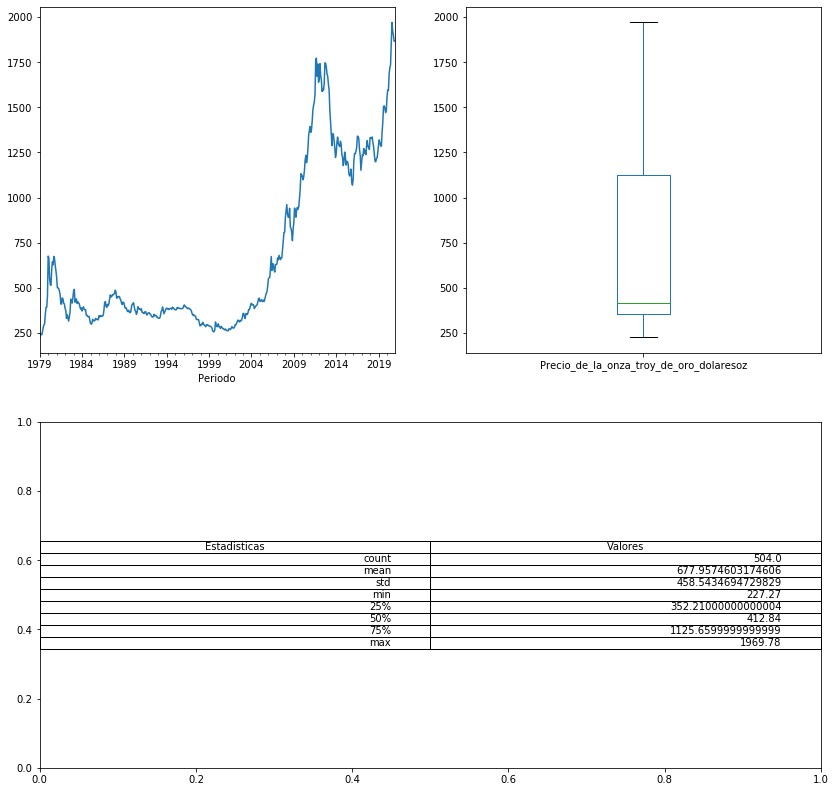

<Figure size 1008x576 with 0 Axes>

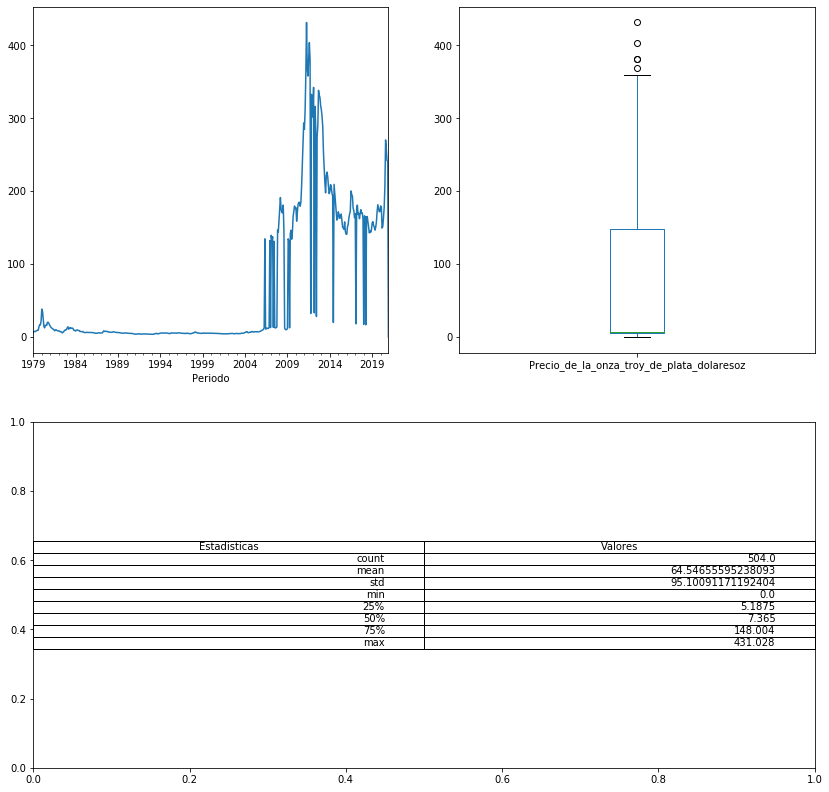

<Figure size 1008x576 with 0 Axes>

In [16]:
plot_caja_serie_estadistica(banco_central)

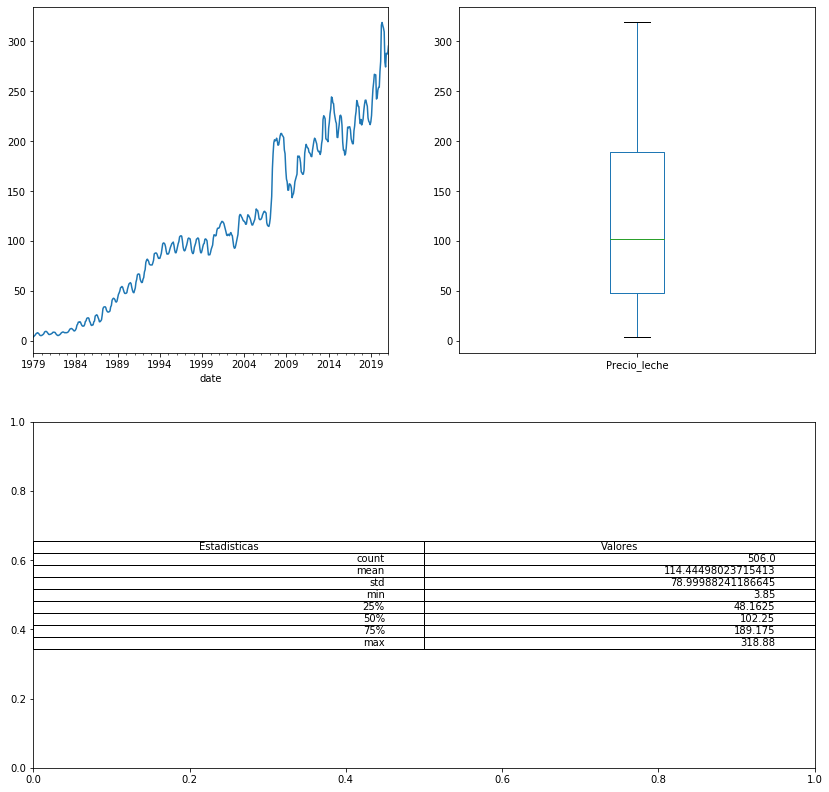

<Figure size 1008x576 with 0 Axes>

In [17]:
plot_caja_serie_estadistica(_precio_leche)

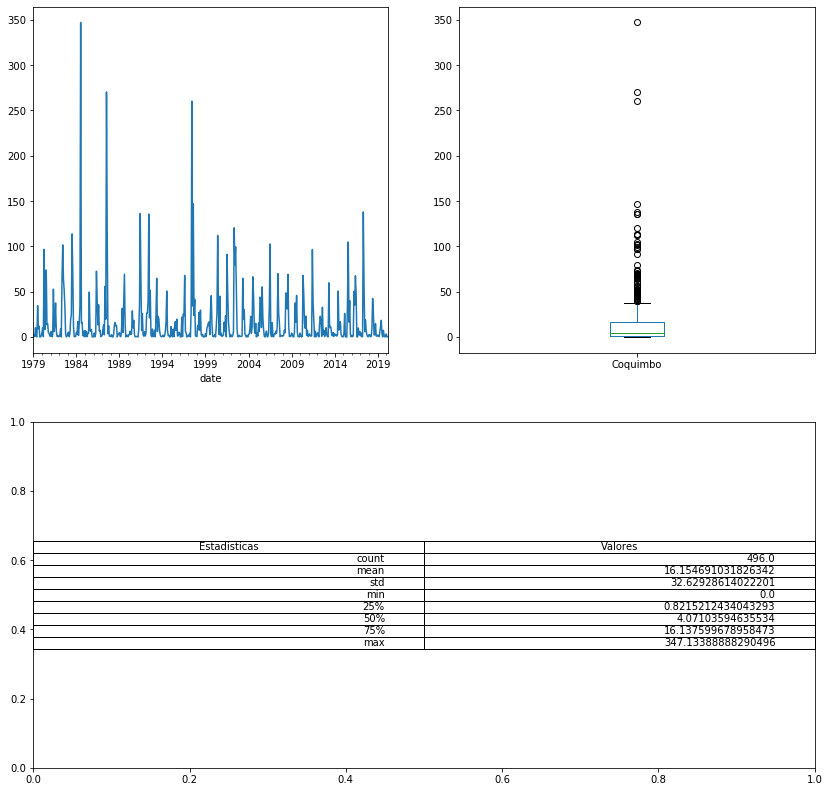

<Figure size 1008x576 with 0 Axes>

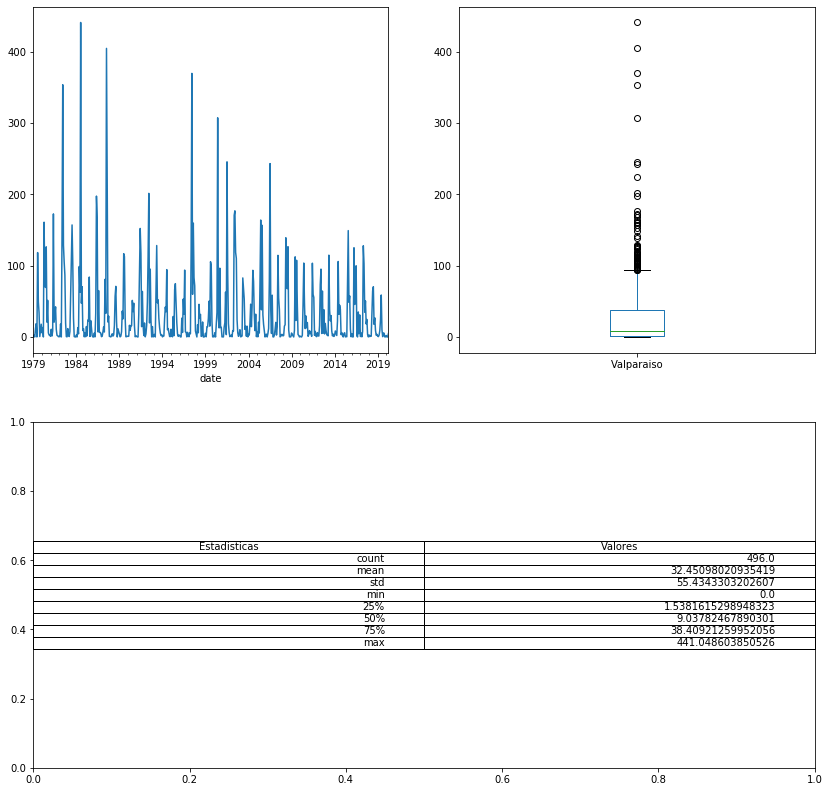

<Figure size 1008x576 with 0 Axes>

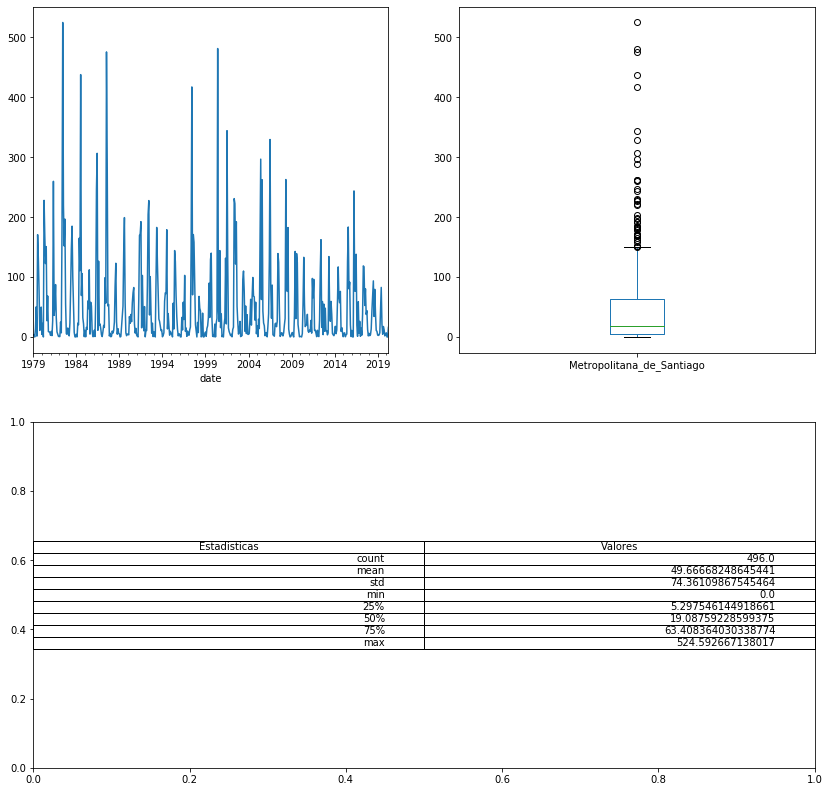

<Figure size 1008x576 with 0 Axes>

In [18]:
plot_caja_serie_estadistica(_precipitaciones)

<div class="alert alert-success" role="alert">
    <h2>2. Análisis de datos.</h2>
     <p align="right"/>
    <ul>
    <b>Realiza un análisis exploratorio de la base de datos, ¿Qué puedes decir de los datos, sus distribuciones, valores faltantes, otros? ¿Hay algo que te llame la atención?</b>
        <li>El primer paso fue eliminar duplicados y acomodar la variable de fecha que es aquella que se utilizará para mezclar los dataframes. </li>
        <li>Las tablas para el precio de la leche y precipitaciones no necesitan mas imputaciones o borrar datos</li>
        <li>La tabla del banco central fue la mas sucia de las tres, hubieron columnas con mas de un punto decimal las cuales se tuvieron que tratar de manera particular ya sea moviendo el punto decimal o eliminandolo</li>
        <li>La variable objetivo es precio_leche y su serie de tiempo comienza en <b>1979</b> por lo que las variables del banco central se recortaron para que cuadren los datos al mezclarlos </li>
        <li>Los valores missings por columna hacen difícil la inferencia para la serie de tiempo, se puede realizar una imputación pero el primer acercamiento es eliminar las features que tengan mas del <b>30%</b> de valores missings para que esta característica pueda aportar información </li>
        <li>Para las series de tiempo individuales podemos ver que la del banco central parece tener mucho ruido blanco y no se observa una tendencia o una clara estacionalidad.</li>
        <li>Para la serie de tiempo del precio de la leche se puede observar una tendencia ascendente con respecto a los años, también se puede inferir estacionalidad que debe ser mensual en los meses en donde haga mas frio en el país</li>
         <li>Para la serie de tiempo del las precipitaciones se podría inferir una autocorrelación pero se debe hacer un análisis quizá de medias moviles para descartar alguna estacionalidad o tendencia.</li>
    </ul>
</div>

# 3. Visualización

Crea una función que permita graficar series históricas de precipitaciones para un rango de fechas determinado. Para esto la función debe recibir como argumentos el nombre de una región, fecha de inicio y fecha de término (asegúrate de verificar en tu función que tanto el nombre de la región como las fechas ingresadas existan en el dataset).

In [19]:
#Funcion para graficar 
def series_precipitaciones(df,region,fecha_inicial,fecha_final,mostrar_grafica_dinamica=True):
    """
    Summary: Función para graficar una región y su comportamiento en un tiempo determinado
    Parameters: Dataframe con una región y dado en fechas, fecha inicial para la serie y fecha final
    mostrar_grafica_dinamica: Sirve para presentar la tabla en plotly de manera dinámica y que esta permita 
    interactuar con los datos, lo mas importante de este parámetro es que permitira hacer zoom para ver los meses.
    Return:None
    """
    fig = go.Figure()
    try:
        serie_grafica = df.loc[(df.index > fecha_inicial) & (df.index < fecha_final),[region]]
    except:
        print('No existe la región: {} o las fechas: {} y {} son incorrectas'.format(region,fecha_inicial,fecha_final))
        return
    fig = px.line(serie_grafica, x=serie_grafica.index, y=region, title='Series históricas de precipitaciones')
    
    if mostrar_grafica_dinamica: fig.show()
    else: fig.show("png")#Se construyó en png para que no haya problemas al exportar a github
    return

- Usa esta función para graficar las precipitaciones para la Región Libertador General Bernardo O'Higgins y para la Región Metropolitana entre las fechas 2000-01-01 y 2020-01-01.
- ¿ Qué observas con respecto a estacionalidades y tendencias?

In [20]:
series_precipitaciones(_precipitaciones,'Libertador_Gral__Bernardo_O_Higgins','2000-01-01','2020-01-01')
series_precipitaciones(_precipitaciones,'Región Metropolitana','2000-01-01','2020-01-01')
series_precipitaciones(_precipitaciones,'Metropolitana_de_Santiago','2000-01-01','2020-01-01')

No existe la región: Región Metropolitana o las fechas: 2000-01-01 y 2020-01-01 son incorrectas


<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
            <li> Para la región <b>Libertador_Gral__Bernardo_O_Higgins</b> se puede observar una estacionalidad anual siendo Julio su mes de punto de inflexión puede ser un mes en donde se encuentren los valores mas bajos o en donde los valores comienzan a bajar, esto se puede observar cambiando el parámetro de la función 'mostrar_grafica_dinamica' a True y haciendo un acercamiento a los años individuales, los puntos mas bajos están en el mes de enero de cada año, este comportamiento se mantiene hasta mayo en donde comienza a subir nuevamente </li>
            <li> Para la región <b>Metropolitana_de_Santiago</b> se puede observar un compotamiento similar a la región pasada, esta región cuenta con practicamente las mismas estacionalidades con los puntos de inflexión un poco mas marcados y siendo Julio el mes en donde la tendencia suele cambiar y los meses alrededor de Julio suelen ser los meses con los valores mas alto, enero se mantiene como el mes con los valores mas bajos hasta mayo en muchos casos, que es donde comienzan a subir los valores nuevamente</li>
        </ul>
    <li>Las dos series son similares con estacionalidades en casi los mismos lugares, de esto podríamos concluir que ambos lugares pueden tener condiciones climaticas similares y podríamos decir que Julio es de los meses mas frios pero al no tener el contexto completo del valor de la variable como sus unidades no se puede hacer una hipotesis completa con respecto a estas variables y su correlación con la variable que se busca predecir.</li>
</div>

Crea una función que, para una región, grafique múltiples series de tiempo mensuales de precipitaciones, donde cada serie de tiempo corresponda a un año. La función debe recibir como argumento una lista con los años que queremos graficar (2000, 2005,..) y el nombre de la región. El eje X debe indicar los meses (enero, febrero, etc...).

In [21]:
def grafica_regiones(df,years,region,mostrar_grafica_dinamica=False):
    """
    Summary: Grafica múltiples series de tiempo de manera mensual
    Parameters: df->Dataframe, years->los años que se quieren visualizar, 
    region->región del dataframe de precipitaciones
    mostrar_grafica_dinamica -> valor default True para mostrar la gráfica en plotly, 
    al cambiarse a False se muestra la gráfica en png
    Return: None
    """
    fig = go.Figure()
    try:
        for year in years:
            fig.add_trace(go.Scatter(x = ['Ene','Feb','Mar','Abr','May','Jun',
                                      'Jul','Ago','Sep','Oct','Nov','Dec'],
                                 y = df.loc[df.index.year == year,[region]][region].to_list(),
                                 mode='lines',
                                 name=str(year)))
        
        fig.update_layout({'title':'Precipitaciones por años'})
        if mostrar_grafica_dinamica: fig.show()
        else: fig.show("png")#Se construyó en png para que no haya problemas al exportar a github
    
    except:
        print('No existe la región: {} o las fechas: {} y {} son incorrectas'.format(region,[years]))
        return

Usa esta función para graficar las precipitaciones para la Región del Maule durante los años 1982, 1992, 2002, 2012 y 2019.

- ¿Qué puedes concluir de estos gráficos?

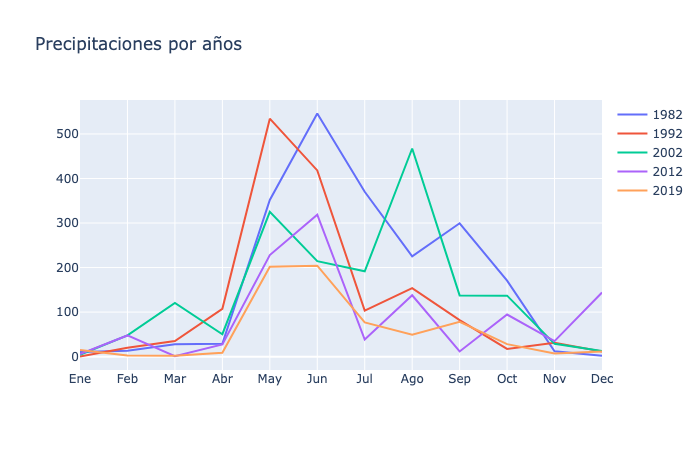

In [22]:
grafica_regiones(_precipitaciones,years = [1982, 1992, 2002, 2012, 2019],region='Maule')


<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
            <li> Para la región <b>Región del Maule</b> en distintos años se puede observar que en general las precipitaciones han ido bajando su valor haciendo que los picos se vayan aplanando con el paso del tiempo, podemos deducir que el clima se ha ido estabilizando y haciendo mas frio con el paso de los años</li>
        </ul>

</div>

Crea una función que permita visualizar dos series históricas de PIB para un rango de fechas determinado. Para esto la función debe recibir como input el nombre de cada serie, fecha de inicio y fecha de término.

In [23]:
def series_PIB(df, nombre_series, fecha_inicio, fecha_termino,mostrar_grafica_dinamica=False):
    """
    Summary: Función que gráfica series de tiempo para el PIB
    Parameters: df->Dataframe, nombre_series->La columna con el tipo de PIB que se va a analizar, 
    fecha_inicio y fecha_final->Rango de fechas que se analizaran
    mostrar_grafica_dinamica -> valor default True para mostrar la gráfica en plotly, 
    al cambiarse a False se muestra la gráfica en png
    Return: None
    """
    fig = go.Figure()
    df = df.loc[(df.index >= fecha_inicio) &
                (df.index <= fecha_termino),nombre_series]
    for serie in nombre_series:
        fig.add_trace(go.Scatter(x = df.index,
                                 y = df[serie],
                                 mode='lines',
                                 name=serie))
    fig.update_layout({'title':'PIBs'})
    if mostrar_grafica_dinamica: fig.show()
    else: fig.show("png")#Se construyó en png para que no haya problemas al exportar a github

Grafica las series de tiempo del PIB agropecuario y silvícola y la del PIB de Servicios financieros desde el 2013-01-01 hasta la fecha más reciente en que haya datos.
- ¿Qué puedes decir de cada serie en particular? o ¿Hay alguna relación entre estas dos series?

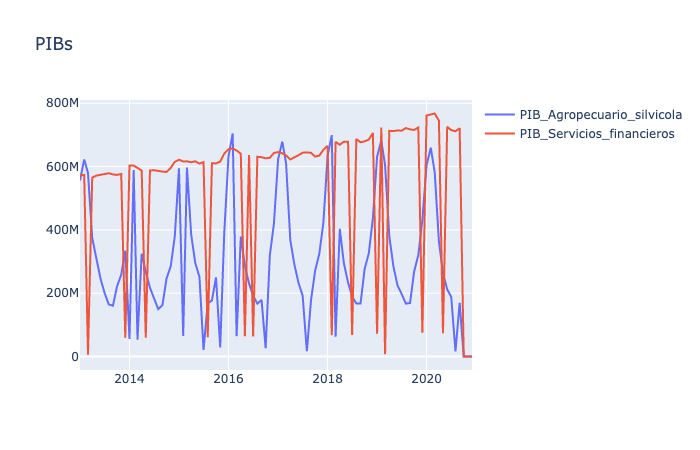

In [24]:
banco_central_vis['PIB_Agropecuario_silvicola'] = banco_central_vis['PIB_Agropecuario_silvicola'].astype(str).apply(limpia_puntos)
banco_central_vis['PIB_Servicios_financieros'] = banco_central_vis['PIB_Servicios_financieros'].astype(str).apply(limpia_puntos)
series_PIB(banco_central_vis, 
           nombre_series = ['PIB_Agropecuario_silvicola','PIB_Servicios_financieros'], 
           fecha_inicio = '2013-01-01', 
           fecha_termino = '2020-12-01')

<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
            <li> Para el <b>PIB_Servicios_financieros</b> en distintos años se puede observar que en general hay una tendencia ascendente, los valles pronunciados se deben a los valores faltantes en la serie</li>
            <li> Para el <b>PIB_Agropecuario_silvicola</b> en distintos años se puede observar que no hay una tendencia y tampoco se observa una clara estacionalidad.</li>
        </ul>

</div>

# 4. Tratamiento y creación de variables

¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo se tienen que correlacionar para entrenar un modelo? ¿Mucha correlación, no correlacionadas, da igual?

In [25]:
#Mezclar las variables para medir la correlación
leche_precipitaciones = pd.merge(_precio_leche,_precipitaciones, on='date', how = 'inner')
data_completa = pd.merge(leche_precipitaciones,banco_central, left_index = True, right_index = True, how = 'inner')
data_completa

Precio_leche   Coquimbo  Valparaiso  Metropolitana_de_Santiago  \
1979-01-01          3.85   2.641948    0.587062                   2.447114   
1979-02-01          4.58   1.179804    2.432192                   3.997852   
1979-03-01          5.18   0.255490    0.020601                   0.000000   
1979-04-01          6.06  10.173699   11.745779                  13.722349   
1979-05-01          7.25   1.039098   18.609286                  50.187148   
...                  ...        ...         ...                        ...   
2019-12-01        253.86   0.287895    0.165390                   3.601443   
2020-01-01        254.10   3.299797    2.003685                   6.937148   
2020-02-01        270.15   0.179216    0.003701                   0.032064   
2020-03-01        279.88   0.003451    0.000666                   0.000000   
2020-04-01        316.25   0.556085    4.664708                  16.033775   

            Libertador_Gral__Bernardo_O_Higgins       Maule      Biobio  \
1979-01-01                             1.608992    3.736215   17.859634   
1979-02-01                             4.346310   16.347637   17.680612   
1979-03-01                             0.055488    0.545324   14.435698   
1979-04-01                            12.989194   21.880607   39.136483   
1979-05-01                           104.451550  143.914334  219.729235   
...                                         ...         ...         ...   
2019-12-01                             6.198806   11.327313   14.014122   
2020-01-01                             6.154279    7.875591   19.518225   
2020-02-01                             0.017628    0.200483   10.108504   
2020-03-01                             0.000000    0.115566   12.462699   
2020-04-01                            19.795752   37.348511   66.764275   

            La_Araucania    Los_Rios  Precio_de_la_gasolina_en_EEUU_dolaresm3  \
1979-01-01     25.212940   45.596447                                   136.72   
1979-02-01     18.085072   34.075039                                   167.13   
1979-03-01     28.696504   66.232248                                   166.71   
1979-04-01     43.617921   73.548127                                   198.31   
1979-05-01    279.409718  438.005116                                   249.33   
...                  ...         ...                                      ...   
2019-12-01     27.321858   62.170090                                   430.27   
2020-01-01     35.916618   63.389625                                   420.60   
2020-02-01     29.001988   55.838889                                   400.42   
2020-03-01     28.310937   73.640866                                   221.55   
2020-04-01     73.813290  140.076757                                   146.57   

            Precio_de_la_onza_troy_de_oro_dolaresoz  \
1979-01-01                                   227.27   
1979-02-01                                   245.67   
1979-03-01                                   242.05   
1979-04-01                                   239.16   
1979-05-01                                   257.61   
...                                             ...   
2019-12-01                                  1482.83   
2020-01-01                                  1559.64   
2020-02-01                                  1595.63   
2020-03-01                                  1592.92   
2020-04-01                                  1686.32   

            Precio_de_la_onza_troy_de_plata_dolaresoz  \
1979-01-01                                      6.260   
1979-02-01                                      7.420   
1979-03-01                                      7.450   
1979-04-01                                      7.490   
1979-05-01                                      8.370   
...                                               ...   
2019-12-01                                    171.946   
2020-01-01                                    179.557   
2020-02-01                 

In [26]:
#Obtener una matriz de correlación
correlation_mat = data_completa.corr()
correlation_mat

Precio_leche  Coquimbo  \
Precio_leche                                            1.000000 -0.054579   
Coquimbo                                               -0.054579  1.000000   
Valparaiso                                             -0.075917  0.912864   
Metropolitana_de_Santiago                              -0.090931  0.813478   
Libertador_Gral__Bernardo_O_Higgins                    -0.082729  0.756140   
Maule                                                  -0.069165  0.656834   
Biobio                                                 -0.045984  0.543010   
La_Araucania                                           -0.022855  0.477211   
Los_Rios                                               -0.001606  0.446142   
Precio_de_la_gasolina_en_EEUU_dolaresm3                 0.718874 -0.038615   
Precio_de_la_onza_troy_de_oro_dolaresoz                 0.808329 -0.085844   
Precio_de_la_onza_troy_de_plata_dolaresoz               0.718896 -0.065767   
Precio_del_cobre_refinado_BML_dolareslibra              0.417537 -0.010617   
Precio_del_petroleo_WTI_dolaresbarril                   0.785936 -0.043831   
Tipo_de_cambio_del_dolar_observado_diario               0.660674  0.045535   
Indice_de_tipo_de_cambio_real___TCR_promedio_19...      0.660787 -0.039364   
Indice_de_produccion_industrial__mineria                0.664710 -0.008673   
Indice_de_produccion_industrial__manufacturera          0.491266  0.002355   

                                                    Valparaiso  \
Precio_leche                                         -0.075917   
Coquimbo                                              0.912864   
Valparaiso                                            1.000000   
Metropolitana_de_Santiago                             0.967567   
Libertador_Gral__Bernardo_O_Higgins                   0.927210   
Maule                                                 0.839412   
Biobio                                                0.730340   
La_Araucania                                          0.655924   
Los_Rios                                              0.609245   
Precio_de_la_gasolina_en_EEUU_dolaresm3              -0.026011   
Precio_de_la_onza_troy_de_oro_dolaresoz              -0.105162   
Precio_de_la_onza_troy_de_plata_dolaresoz            -0.087386   
Precio_del_cobre_refinado_BML_dolareslibra           -0.012320   
Precio_del_petroleo_WTI_dolaresbarril                -0.047356   
Tipo_de_cambio_del_dolar_observado_diario             0.000784   
Indice_de_tipo_de_cambio_real___TCR_promedio_19...   -0.040092   
Indice_de_produccion_industrial__mineria             -0.022689   
Indice_de_produccion_industrial__manufacturera        0.001056   

                                                    Metropolitana_de_Santiago  \
Precio_leche                                                        -0.090931   
Coquimbo                                                             0.813478   
Valparaiso                                                           0.967567   
Metropolitana_de_Santiago                                            1.000000   
Libertador_Gral__Bernardo_O_Higgins                                  0.976389   
Maule                                                                0.904947   
Biobio                                                               0.804073   
La_Araucania                                                         0.729807   
Los_Rios                                                             0.677950   
Precio_de_la_gasolina_en_EEUU_dolaresm3                             -0.026161   
Precio_de_la_onza_troy_de_oro_dolaresoz                             -0.119705   
Precio_de_la_onza_troy_de_plata_dolaresoz                           -0.101896   
Precio_del_cobre_refinado_BML_dolareslibra                          -0.012714   
Precio_del_petroleo_WTI_dolaresbarril                               -0.058089   
Tipo_de_cambio_del_dolar_observado_diario                           -0.028593   
Indice_de_tipo_de_

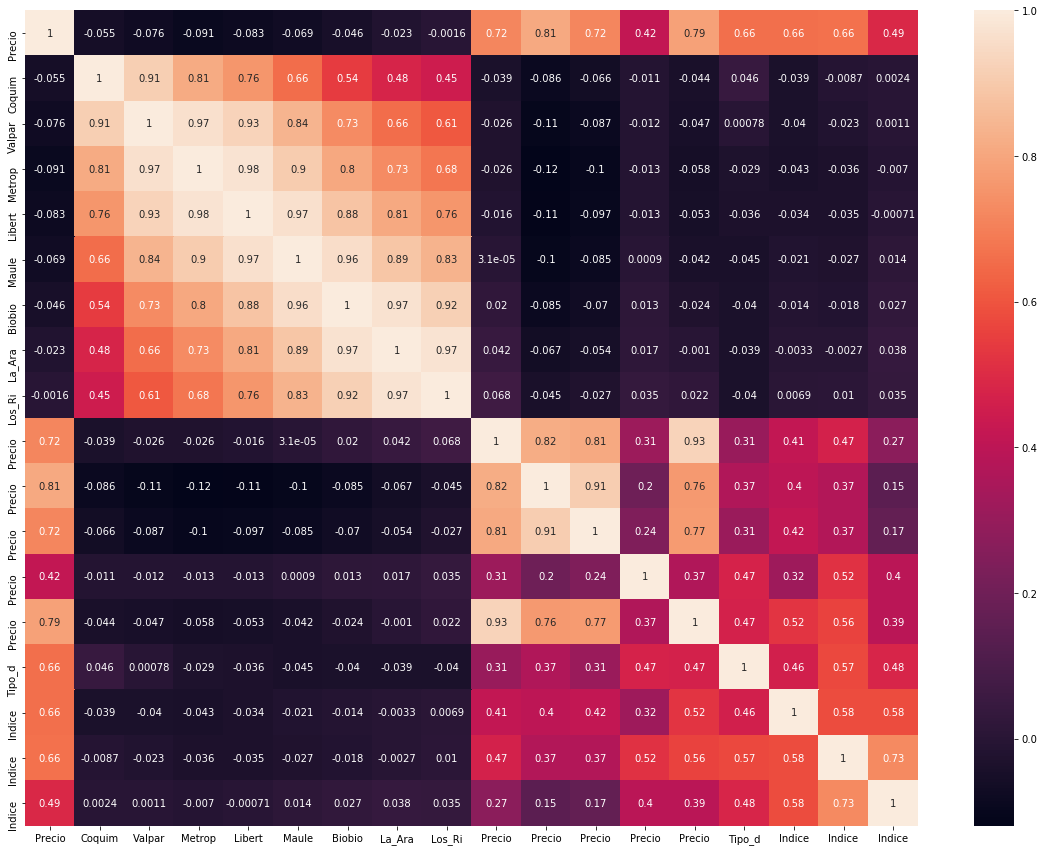

In [27]:
#Recortar los nombres de la matriz para su visualización
correlation_mat.columns = [columna[0:6] for columna in correlation_mat.columns]
correlation_mat.index = [columna[0:6] for columna in correlation_mat.index]
plt.subplots(figsize=(20,15))
sns.heatmap(correlation_mat, annot = True)

In [28]:
correlation_mat.columns

Index(['Precio', 'Coquim', 'Valpar', 'Metrop', 'Libert', 'Maule', 'Biobio',
       'La_Ara', 'Los_Ri', 'Precio', 'Precio', 'Precio', 'Precio', 'Precio',
       'Tipo_d', 'Indice', 'Indice', 'Indice'],
      dtype='object')

<div class="alert alert-success" role="alert">
    <h2>2. Análisis de datos.</h2>
     <p align="right"/>
    <ul>
    <b>¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo se tienen que correlacionar para entrenar un modelo? ¿Mucha correlación, no correlacionadas, da igual?</b>
        <li>Para este caso se utilizó correlación de Pearson para evaluar la correlación entre variables</li>
        <li>En el mapa de calor podemos observar que las variables que están mas correlacionadas con el precio de la leche son <b>[Precio_de_la_gasolina_en_EEUU_dolaresm3',
       'Precio_de_la_onza_troy_de_oro_dolaresoz',
       'Precio_de_la_onza_troy_de_plata_dolaresoz',
       'Precio_del_cobre_refinado_BML_dolareslibra',
       'Precio_del_petroleo_WTI_dolaresbarril',
       'Tipo_de_cambio_del_dolar_observado_diario',
       'Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100',
       'Indice_de_produccion_industrial__mineria',
            'Indice_de_produccion_industrial__manufacturera]</b> que son los precios y los indices</li>
        <li>La hipotesis aquí nos dice que pueden haber mas valores de PIB correlacionados pero se tuvieron que eliminar previamente por la cantidad de valores missings en aquellas variables</li>
        <li>Las variables de precipitaciones están pobremente e inversamente correlacionadas por lo que para este modelo no aportarían información</li>
        <li>En este caso nos sirve que las variables estén correlacionadas entre un <b>0.5 y un 0.8</b> como máximo puesto que la correlación nos habla de que tan relacionadas están dos variables, si fuera la correlación igual a 1, esto dice que ambas variables serán identicas en compotamiento a través del tiempo, y si es cero quiere decir que no hay ningún patrón que las variables vayan a seguir a través del tiempo, si es negativa como es el caso de las variables de precipitaciones quiere decir que mientras una variable toma una dirección en el tiempo, la otra hará lo contrario, pero al ser una correlación de menos del 10% no se puede asumir que su compotamiento sea estable con respecto al precio de la leche y es por esto que estas variables no se ocuparan para este ejercicio.</li>
    </ul>
</div>

In [29]:
###
# Creación de variables
###
# Variable año
data_completa['Year'] = data_completa.index.year
data_completa['Mes'] = data_completa.index.month
data_completa['Trimestre'] = data_completa.index.quarter
data_completa

Precio_leche   Coquimbo  Valparaiso  Metropolitana_de_Santiago  \
1979-01-01          3.85   2.641948    0.587062                   2.447114   
1979-02-01          4.58   1.179804    2.432192                   3.997852   
1979-03-01          5.18   0.255490    0.020601                   0.000000   
1979-04-01          6.06  10.173699   11.745779                  13.722349   
1979-05-01          7.25   1.039098   18.609286                  50.187148   
...                  ...        ...         ...                        ...   
2019-12-01        253.86   0.287895    0.165390                   3.601443   
2020-01-01        254.10   3.299797    2.003685                   6.937148   
2020-02-01        270.15   0.179216    0.003701                   0.032064   
2020-03-01        279.88   0.003451    0.000666                   0.000000   
2020-04-01        316.25   0.556085    4.664708                  16.033775   

            Libertador_Gral__Bernardo_O_Higgins       Maule      Biobio  \
1979-01-01                             1.608992    3.736215   17.859634   
1979-02-01                             4.346310   16.347637   17.680612   
1979-03-01                             0.055488    0.545324   14.435698   
1979-04-01                            12.989194   21.880607   39.136483   
1979-05-01                           104.451550  143.914334  219.729235   
...                                         ...         ...         ...   
2019-12-01                             6.198806   11.327313   14.014122   
2020-01-01                             6.154279    7.875591   19.518225   
2020-02-01                             0.017628    0.200483   10.108504   
2020-03-01                             0.000000    0.115566   12.462699   
2020-04-01                            19.795752   37.348511   66.764275   

            La_Araucania    Los_Rios  Precio_de_la_gasolina_en_EEUU_dolaresm3  \
1979-01-01     25.212940   45.596447                                   136.72   
1979-02-01     18.085072   34.075039                                   167.13   
1979-03-01     28.696504   66.232248                                   166.71   
1979-04-01     43.617921   73.548127                                   198.31   
1979-05-01    279.409718  438.005116                                   249.33   
...                  ...         ...                                      ...   
2019-12-01     27.321858   62.170090                                   430.27   
2020-01-01     35.916618   63.389625                                   420.60   
2020-02-01     29.001988   55.838889                                   400.42   
2020-03-01     28.310937   73.640866                                   221.55   
2020-04-01     73.813290  140.076757                                   146.57   

            Precio_de_la_onza_troy_de_oro_dolaresoz  \
1979-01-01                                   227.27   
1979-02-01                                   245.67   
1979-03-01                                   242.05   
1979-04-01                                   239.16   
1979-05-01                                   257.61   
...                                             ...   
2019-12-01                                  1482.83   
2020-01-01                                  1559.64   
2020-02-01                                  1595.63   
2020-03-01                                  1592.92   
2020-04-01                                  1686.32   

            Precio_de_la_onza_troy_de_plata_dolaresoz  \
1979-01-01                                      6.260   
1979-02-01                                      7.420   
1979-03-01                                      7.450   
1979-04-01                                      7.490   
1979-05-01                                      8.370   
...                                               ...   
2019-12-01                                    171.946   
2020-01-01                                    179.557   
2020-02-01                 

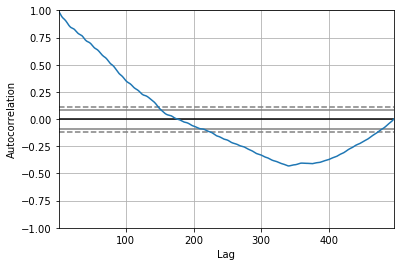

In [30]:
autocorrelation_plot(data_completa.Precio_leche)
#Serie con tendencia creciente en nuestra variable Target

In [31]:
# Lag a un mes
autocorr_mes = data_completa.Precio_leche.autocorr(lag=1)
print(f"Con un lag igual a un mes y correlación de Pearson, obtenemos una correlación de: {autocorr_mes}")
print(f"Promedio: {data_completa.Precio_leche.mean()} Promedio t-1: {data_completa.Precio_leche.shift(periods=1).mean()}")
print(f"Varianza: {data_completa.Precio_leche.var()} Varianza t-1: {data_completa.Precio_leche.shift(periods=1).var()}")
# Lag a un trimestre
autocorr_tri = data_completa.Precio_leche.autocorr(lag=3)
print(f"Con un lag igual a un trimestre y correlación de Pearson, obtenemos una correlación de: {autocorr_mes}")
print(f"Promedio: {data_completa.Precio_leche.mean()} Promedio t-3: {data_completa.Precio_leche.shift(periods=3).mean()}")
print(f"Varianza: {data_completa.Precio_leche.var()} Varianza t-3: {data_completa.Precio_leche.shift(periods=1).var()}")
# Lag a un año
autocorr_year = data_completa.Precio_leche.autocorr(lag=12)
print(f"Con un lag igual a un año y correlación de Pearson, obtenemos una correlación de: {autocorr_year}")
print(f"Promedio: {data_completa.Precio_leche.mean()} Promedio t-12: {data_completa.Precio_leche.shift(periods=12).mean()}")
print(f"Varianza: {data_completa.Precio_leche.var()} Varianza t-12: {data_completa.Precio_leche.shift(periods=1).var()}")
## Serie con estacionalidad.

Con un lag igual a un mes y correlación de Pearson, obtenemos una correlación de: 0.997923292240995
Promedio: 110.76663306451611 Promedio t-1: 110.35151515151513
Varianza: 5676.291412681243 Varianza t-1: 5602.136711262426
Con un lag igual a un trimestre y correlación de Pearson, obtenemos una correlación de: 0.997923292240995
Promedio: 110.76663306451611 Promedio t-3: 109.68350912778904
Varianza: 5676.291412681243 Varianza t-3: 5602.136711262426
Con un lag igual a un año y correlación de Pearson, obtenemos una correlación de: 0.9726126958283707
Promedio: 110.76663306451611 Promedio t-12: 106.96363636363634
Varianza: 5676.291412681243 Varianza t-12: 5602.136711262426


<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
     <p align="right"/>
    <ul>
        <li>Cuando hay estacionalidad se puede ver que el promedio y la desviación estandar se mantiene en valores similares, si fueran una estacionalidad sin ningun tipo de ruido los valores serían los mismos</li>
        <li>En este caso se puede observar que si existe una estacionalidad y anteriormente se comprobo que también existe una tendencia</li>
        <li>Una serie de tiempo puede contar con estacionalidad, tendencia y ruido blanco al mismo tiempo</li>
    </ul>
</div>

# 5. Modelo

Entrena un modelo que permita predecir el precio de la leche el próximo mes, en función de los datos entregados.

In [32]:
#Features que se utilizaran para la predicción de la serie de tiempo multivariable
data_model = data_completa[['Precio_leche','Precio_de_la_gasolina_en_EEUU_dolaresm3',
       'Precio_de_la_onza_troy_de_oro_dolaresoz',
       'Precio_de_la_onza_troy_de_plata_dolaresoz',
       'Precio_del_cobre_refinado_BML_dolareslibra',
       'Precio_del_petroleo_WTI_dolaresbarril',
       'Tipo_de_cambio_del_dolar_observado_diario',
       'Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100',
       'Indice_de_produccion_industrial__mineria',
       'Indice_de_produccion_industrial__manufacturera']]

fechas = data_completa.index

fechas

DatetimeIndex(['1979-01-01', '1979-02-01', '1979-03-01', '1979-04-01',
               '1979-05-01', '1979-06-01', '1979-07-01', '1979-08-01',
               '1979-09-01', '1979-10-01',
               ...
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', length=496, freq=None)

In [33]:
#LSTM requiere de datos normalizados
scaler = StandardScaler()
scaler = scaler.fit(data_model)
data_model_scaled = scaler.transform(data_model)

Construye una base de test (o de cross validation). ¿Cuál fue tu definición de tiempo/cantidad de datos para este set de datos? Explica por qué la elegiste así.

In [34]:
#Se tomará una ventana de 3 meses como valores en x y 1 mes como valor en y, esta ventana se movera i veces 
#en el for para crear una matriz de dimensiones: (numero de filas, numero de valores de ventana, numero de features) 
trainX = []
trainY = []

n_mes_futuro = 1   # Numero de meses a predecir en el futuro
n_trimestre = 3     # Numero de meses en el pasado que se utilizaran para predecir el valor futuro

for i in range(n_trimestre, len(data_model_scaled) - n_mes_futuro +1):
    trainX.append(data_model_scaled[i - n_trimestre:i, 0:data_model_scaled.shape[1]])
    trainY.append(data_model_scaled[i + n_mes_futuro - 1:i + n_mes_futuro, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape:  {}.'.format(trainX.shape))
print('trainY shape:  {}.'.format(trainY.shape))

trainX shape:  (493, 3, 10).
trainY shape:  (493, 1).


In [35]:
#Se define un modelo de LSTM en donde los parametros finales fueron definidos a través de experimentación
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 64)             19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Los hiperparametros se definieron con un proceso iterativo de experimentación y se tienen 10% de los datos
#Para validación
history = model.fit(trainX, trainY, epochs=15, batch_size=16, validation_split=0.1, verbose=1)

Train on 443 samples, validate on 50 samples
Epoch 1/15
443/443 [==============================] - 5s 12ms/sample - loss: 0.6144 - val_loss: 2.0060
Epoch 2/15
443/443 [==============================] - 0s 885us/sample - loss: 0.1189 - val_loss: 1.0467
Epoch 3/15
443/443 [==============================] - 0s 854us/sample - loss: 0.0774 - val_loss: 0.5107
Epoch 4/15
443/443 [==============================] - 0s 839us/sample - loss: 0.0497 - val_loss: 0.3607
Epoch 5/15
443/443 [==============================] - 0s 853us/sample - loss: 0.0475 - val_loss: 0.3174
Epoch 6/15
443/443 [==============================] - 0s 842us/sample - loss: 0.0405 - val_loss: 0.1082
Epoch 7/15
443/443 [==============================] - 0s 869us/sample - loss: 0.0406 - val_loss: 0.0618
Epoch 8/15
443/443 [==============================] - 0s 892us/sample - loss: 0.0338 - val_loss: 0.1145
Epoch 9/15
443/443 [==============================] - 0s 854us/sample - loss: 0.0375 - val_loss: 0.0653
Epoch 10/15
443/443 

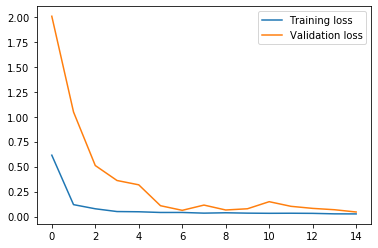

In [50]:
#Graficación de entrenamiento y validación
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [51]:
n_future=120#Definir los valores a futuro para visualizar la serie
forecast_period_dates = pd.date_range((fechas)[-98], periods=n_future, freq='MS').tolist() 
#El valor negativo indica que va a gráficar sus valores predichos también "hacia el pasado" para compararlo
#con la serie original

In [39]:
forecast_period_dates

[Timestamp('2012-03-01 00:00:00', freq='MS'),
 Timestamp('2012-04-01 00:00:00', freq='MS'),
 Timestamp('2012-05-01 00:00:00', freq='MS'),
 Timestamp('2012-06-01 00:00:00', freq='MS'),
 Timestamp('2012-07-01 00:00:00', freq='MS'),
 Timestamp('2012-08-01 00:00:00', freq='MS'),
 Timestamp('2012-09-01 00:00:00', freq='MS'),
 Timestamp('2012-10-01 00:00:00', freq='MS'),
 Timestamp('2012-11-01 00:00:00', freq='MS'),
 Timestamp('2012-12-01 00:00:00', freq='MS'),
 Timestamp('2013-01-01 00:00:00', freq='MS'),
 Timestamp('2013-02-01 00:00:00', freq='MS'),
 Timestamp('2013-03-01 00:00:00', freq='MS'),
 Timestamp('2013-04-01 00:00:00', freq='MS'),
 Timestamp('2013-05-01 00:00:00', freq='MS'),
 Timestamp('2013-06-01 00:00:00', freq='MS'),
 Timestamp('2013-07-01 00:00:00', freq='MS'),
 Timestamp('2013-08-01 00:00:00', freq='MS'),
 Timestamp('2013-09-01 00:00:00', freq='MS'),
 Timestamp('2013-10-01 00:00:00', freq='MS'),
 Timestamp('2013-11-01 00:00:00', freq='MS'),
 Timestamp('2013-12-01 00:00:00', 

In [52]:
forecast = model.predict(trainX[-n_future:]) #predicción 

In [53]:
forecast_copies = np.repeat(forecast, data_model.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [54]:
y_pred_future

array([174.2357 , 178.45909, 182.75189, 186.33969, 185.999  , 183.51886,
       179.26772, 176.73067, 176.58493, 178.12875, 179.00095, 186.05515,
       192.31879, 201.22665, 197.6815 , 194.59576, 192.32256, 191.52017,
       193.26216, 193.11127, 193.48877, 200.93173, 198.78712, 198.61926,
       202.85895, 212.32285, 213.66905, 201.24478, 195.98892, 198.0101 ,
       200.64447, 197.52838, 195.49612, 196.69446, 195.9846 , 197.42851,
       199.9658 , 207.2019 , 210.05809, 220.7278 , 225.09717, 226.22876,
       217.15431, 205.72954, 210.37027, 218.66765, 225.70566, 234.44716,
       244.63525, 252.21227, 249.15462, 249.8426 , 232.99474, 225.54425,
       220.56686, 220.45259, 217.94151, 206.78175, 204.07881, 206.54523,
       214.74687, 219.94846, 218.10501, 222.0244 , 217.25493, 209.87523,
       195.56421, 202.08713, 199.61867, 200.16914, 192.47644, 192.63358,
       202.5474 , 209.5917 , 219.34705, 214.96786, 217.3426 , 215.11739,
       213.57227, 199.17284, 197.77606, 202.07245, 

In [55]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
forecast_dates
df_forecast = pd.DataFrame({'Date':np.array(forecast_period_dates), 'Precio_leche':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [58]:
# Crear el gráfico para observar la comparación de los graficos de la serie real y su predicción
aux = data_model.loc[data_model.index >= '2015-01-01',['Precio_leche']]

fig = go.Figure()
fig.add_trace(go.Scatter(x=aux.index, y=aux['Precio_leche'],
                    mode='lines+markers',
                    name='Serie real'))
fig.add_trace(go.Scatter(x=df_forecast['Date'], y=df_forecast['Precio_leche'],
                    mode='lines+markers',
                    name='Predicción'))
fig.update_layout({'title':'Gráfico de desempeño de la serie de tiemo'},
                    xaxis_title='Tiempo (año - mes)',
                    yaxis_title='Precio de la leche')
fig.show()

In [45]:
#model_prediction_save = model.save('precio_leche_predict.h5')

¿Cómo evalúas el resultado del modelo?¿Qué métricas tiene sentido mirar?

In [46]:
data_model['Precio_leche'][-121:-1].values.reshape((120,1)).shape

(120, 1)

In [47]:
forecast.shape

(120, 1)

In [48]:
errores = forecast - data_model['Precio_leche'][-121:-1].values.reshape((120,1))
mse = np.square(errores).mean()
rmse = np.sqrt(mse)
mae = np.abs(errores).mean()
mape = np.abs(errores / data_model['Precio_leche'][-121:-1].values.reshape((120,1))).mean()

In [49]:
print(f"""MSE: {mse}
RMSE: {rmse}
MAE: {mae}
MAPE: {mape}""")

MSE: 45382.89112305756
RMSE: 213.03260577446252
MAE: 211.65831981144348
MAPE: 0.9935151351236334


¿Qué datos adicionales te gustaría tener?¿Qué datos son necesarios para que este modelo funcione/mejore las métricas?

¿Para qué aplicaciones puede servir un modelo de este tipo? En particular, ¿Cómo
podría ayudar a combatir el cambio climático?

<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
     <p align="right"/>
    <ul>
        <li>Sería bueno tener el valor de inflación del país puesto que con este dato sabemos como fluctua la canasta básica.</li>
        <li>En este caso las métricas de RMSE y MAE son las que mas nos pueden dar una idea del error que estamos observando de manera mas real, el MSE resalta los errores grandes, pero en este caso al ser el precio de la leche la variable a predecir se considera que no es necesario resaltar los errores grandes, es mejor tener una idea mas precisa de cual es el error que se esta presentando, el MAPE nos dara un ratio con la relación del valor de los errores y el precio predicho, algo así como un accuracy, aunque no es lo mismo.</li>
        <li>Un modelo así puede tener aplicaciones para publicidad de leche, también puede utilizarse en combinación con un modelo de market basket puesto que la leche es un producto que se puede comprar con otros alimentos para multiples públicos, además le puede servir al área gubernamental para darse una idea de las fluctuaciones de este producto también con respecto al clima</li>
        <li>La tabla de precipitaciones nos puede dar una idea muy clara de como el clima cambia con respecto del tiempo y sus repercusiones hasta en la compra de ciertos productos, que si bien pudieran ser correlaciones espurias otras pueden encender focos de alarma sobre el consumo no solo de la leche sino de mucho otros productos</li>
    </ul>
</div>